In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle,os
from sklearn.preprocessing import StandardScaler

In [2]:
import umap

def candidate_genes_umap_transformation(exp_m,metadata,candidate_genes,scale=True) :

    target_genes = list(set(exp_m.index).intersection(candidate_genes))
    target_x = exp_m.loc[target_genes,:]
    target = exp_m.columns
    #UMAP transformation
    reducer = umap.UMAP()
    if scale :
        scaler = StandardScaler()
        stand_x = scaler.fit_transform(target_x.to_numpy())
        embedding = reducer.fit_transform(stand_x.T)
    else :
        embedding = reducer.fit_transform(target_x.T)
    #transform UMAP embedding to seaborn input
    embedding_df = pd.DataFrame({'UMAP1' : embedding[:,0],'UMAP2' : embedding[:,1],'Celltype' :metadata.loc[target,'Celltype'],# type: ignore
    'Site' :metadata.loc[target,'site'],'Patient' :metadata.loc[target,'patient'],'Stage' :metadata.loc[target,'stage']})
    
    return embedding_df

In [3]:
class function_module :
    def __init__(self,summary_dataframe,sheet_list,protein_network) :
        self.summary : pd.io.excel._base.ExcelFile = summary_dataframe # type: ignore
        self.condition : list = sheet_list
        self.check_sheet_name()
        self.protein_network : str = protein_network
        
    def check_sheet_name(self) :
        for c in self.condition :
            if c not in self.summary.sheet_names :
                raise ValueError("Sheet name : %s not exist in given excel file" % c) 
    
    def functional_module_goinfo(self) :
        go_info = dict()
        for condition in self.condition :
            go_info[condition] = {}
            df = self.summary.parse(condition)
            df.index = df['GOID']
            for go in df.index :
                go_info[condition][go] = (df.loc[go,'Description'],df.loc[go,'#Nodes'])
        return go_info
    
    def edge2node(self,edge_context) :
        '''
        edge_list : str, like 'ENSG00000115415 ENSG00000138496_ENSG00000115415 ENSG00000168961_ENSG00000115415, underline as seperator
        '''
        edge_l = edge_context.split('_')
        node_l = set(list(map(lambda x : x.split(' ')[0],edge_l)) + list(map(lambda x : x.split(' ')[1],edge_l)))
        return list(node_l)
    
    def extract_expression_profile_of_module(self,summary_table,go_id,expression_profile):
        # expression_profile , row is gene (ensID) column is sample
        e = summary_table.loc[go_id,'Edges']
        gene_list = self.edge2node(e)
        return expression_profile.loc[set(gene_list).intersection(expression_profile.index),:]   


In [4]:
functional_module_path = '/home/bruce1996/data/LIHC_anomaly_detection/functional_profiling/candidate_functional_module/'
grn_xl = pd.ExcelFile(functional_module_path + 'Summary_table_of_%s_FunModu.xlsx' % 'GRN')
pin_xl = pd.ExcelFile(functional_module_path + 'Summary_table_of_%s_FunModu.xlsx' % 'PIN')
condition = ['hbv_only_35','nonhbv_only_20','tumor_only_25','normal_only_15']
grn_summary = function_module(grn_xl,condition,'GRN')
pin_summary = function_module(pin_xl,condition,'PIN')

In [5]:
def extract_functional_module_express(expression_matrix,fun_module,metadata,output_path) :
    if os.path.exists(output_path) == False :
        os.mkdir(output_path)
    for c in fun_module.condition :
        summary = fun_module.summary.parse(c)
        summary.index = summary['GOID']
        for go in summary['GOID'] :
            print("Manifold transformation of GO : %s in %s PPI network of condition %s !" % (go,fun_module.protein_network,c))
            sub_m = fun_module.extract_expression_profile_of_module(summary,go,expression_matrix)
            umap_embedding = candidate_genes_umap_transformation(sub_m,metadata,sub_m.index)
            umap_embedding.to_csv(output_path + 'umap_mainfold_transformation_of_GO_%s_in_%s_%s.txt' % (go,fun_module.protein_network,c),sep='\t')


In [ ]:
with open("/home/bruce1996/data/LIHC_anomaly_detection/validation_dataset/scRNA/GSE149614_HCC_hepatocyte_normalized.pkl",'rb') as f :
    exp_m = pickle.load(f)
f.close()
metadata = pd.read_csv('/home/bruce1996/data/LIHC_anomaly_detection/validation_dataset/scRNA/GSE149614_HCC.metadata.txt',sep='\t',index_col=0)
output_path = '/home/bruce1996/data/LIHC_anomaly_detection/manifold_transformation/functional_module_transform/'
extract_functional_module_express(exp_m,pin_summary,metadata,output_path)

In [65]:
def plot_manifold_transformation(data,xaxis,yaxis,hue,title,output_path) :
    plt.figure(figsize=(10,6))
    sns.scatterplot(data=data,x=xaxis,y=yaxis,hue=hue,palette="Set2",alpha=0.5,s=100)
    plt.title(title)
    plt.legend(ncol=2,bbox_to_anchor=(1, 1))
    plt.savefig(output_path,dpi = 300,bbox_inches='tight')

In [ ]:
embedding_path = '/home/bruce1996/data/LIHC_anomaly_detection/manifold_transformation/functional_module_transform/'
output_path = '/home/bruce1996/data/LIHC_anomaly_detection/fig/functional_module/manifold_transformation/'
pin_go_info = pin_summary.functional_module_goinfo()
grn_go_info = grn_summary.functional_module_goinfo()
condition_d = {'hbv':'hbv_only_35','nonhbv':'nonhbv_only_20','tumor':'tumor_only_25','normal':'normal_only_15'}

for file in os.listdir(embedding_path) :
    df = pd.read_csv(embedding_path + file,sep='\t',index_col=0)
    name = file.split('_')
    print(name)
    go = name[5]
    protein_network = name[7]
    condition = name[8]
    if protein_network == 'GRN' :
        if go not in grn_go_info[condition_d[condition]] :
            continue
        description, n_nodes = grn_go_info[condition_d[condition]][go]
    else :
        if go not in pin_go_info[condition_d[condition]] :
            continue
        description, n_nodes = pin_go_info[condition_d[condition]][go]

    title = "Manifold transformation of %s %s (gene=%d) in %s (%s)" % (go,description,n_nodes,protein_network,condition)
    print(title)
    fig_name = output_path + file.replace('.txt','.png')
    plot_manifold_transformation(df,'UMAP1','UMAP2','Stage',title,fig_name)

### functional module vote number

In [6]:
def vote_distribution(module,vote_result,prefix,output_path) :
    for condition in module.condition :
        df = module.summary.parse(condition)
        df.index = df['GOID']
        vote_df = pd.DataFrame()
        for go in df.index :
            gene_list = df.loc[go,'Nodes'].split('_')
            vote = vote_result.loc[gene_list,'Vote']
            result = pd.DataFrame({'Gene' : gene_list,'GO' : [go] * len(gene_list),'Vote' : vote})
            vote_df = pd.concat([vote_df,result])
        vote_df.to_csv(output_path + '%s_funModu_vote_result_%s.txt' % (prefix,condition),sep='\t')

def plot_vote_distribution(vote_result,module,prefix,title,output_path) :

    go_info = module.functional_module_goinfo()
    for condition in module.condition :
        plt.figure(figsize=(10,5))
        ax = sns.boxplot(data=vote_result,x='GO',y='Vote',palette='rainbow_r')
        label = [x.get_text() for x in ax.get_xticklabels()]
        description = [go_info[condition][x][0] for x in label]
        ax.set_xticklabels(description,rotation=90)
        ax.set_title("Vote result of %s functional module (%s)" % (prefix,condition))
        plt.savefig(output_path + "%s_funModu_vote_result_%s.png" % (prefix,condition),dpi = 300,bbox_inches='tight')

def functional_module_vote_result(vote_result_path,vote_result_prefix,functional_module,ppi_network,output_path) :
    '''
    vote_result_path : str, path of vote result with corresponding to module condition
    vote_result_prefix : str, prefix of vote result file, like "std_by_gene_vote_np_ratio"
    functional_module : class functional_module 
    '''
    # save vote result into dict vote_d
    vote_d = {}
    condition = functional_module.condition # type: ignore
    for c in condition :
        con = c.split('_')[0] + '_' + c.split('_')[1]
        np_ratio = c.split('_')[-1]
        vote_result = pd.read_csv(vote_result_path + '%s_%s_%s.txt' % (con,vote_result_prefix,np_ratio),sep='\t',index_col=0)
        vote_d[c] = vote_result
    #processing functional module information
    for condition in functional_module.condition : # type: ignore
        df = functional_module.summary.parse(condition) # type: ignore
        df.index = df['GOID']
        vote_df = pd.DataFrame()
        for go in df.index :
            e = df.loc[go,'Edges']
            gene_list = functional_module.edge2node(e) # type: ignore
            vote = vote_d[condition].loc[gene_list,'Vote']
            result = pd.DataFrame({'Gene' : gene_list,'GO' : [go] * len(gene_list),'Vote' : vote})
            vote_df = pd.concat([vote_df,result])
        vote_df.to_csv(output_path + '%s_funModu_vote_result_%s.txt' % (ppi_network,condition),sep='\t')

In [14]:
module = pin_summary
ppi_network = 'PIN'
vote_path = '/home/bruce1996/data/LIHC_anomaly_detection/ensemble_result/vote_result/'
vote_prefix = 'std_by_gene_vote_np_ratio'
output_path = '/home/bruce1996/data/LIHC_anomaly_detection/functional_profiling/module_vote_result/'
functional_module_vote_result(vote_path,vote_prefix,module,ppi_network,output_path)

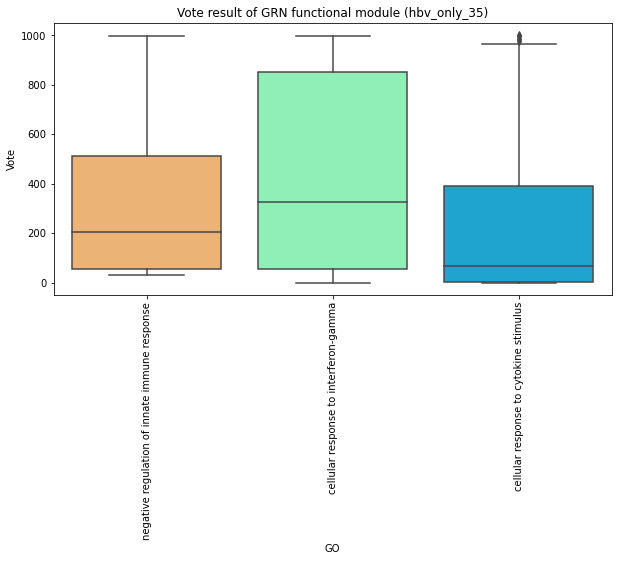

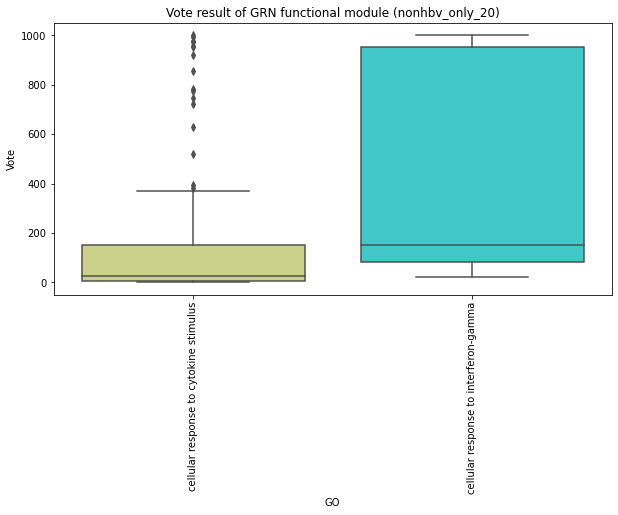

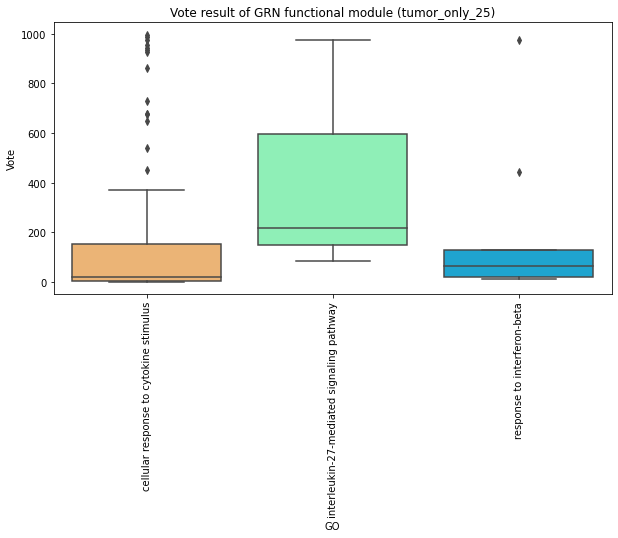

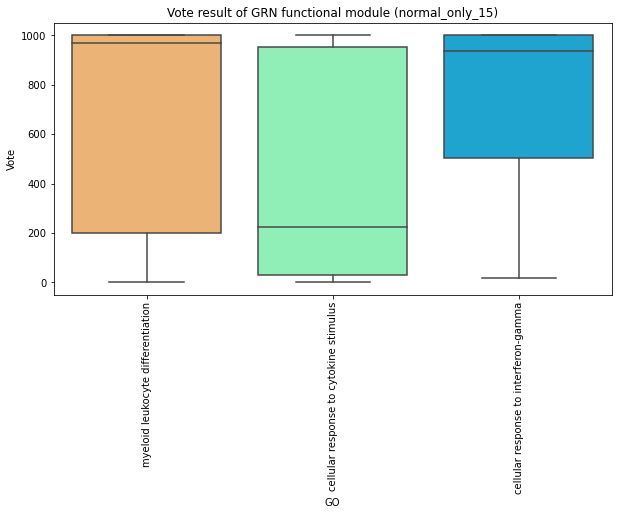

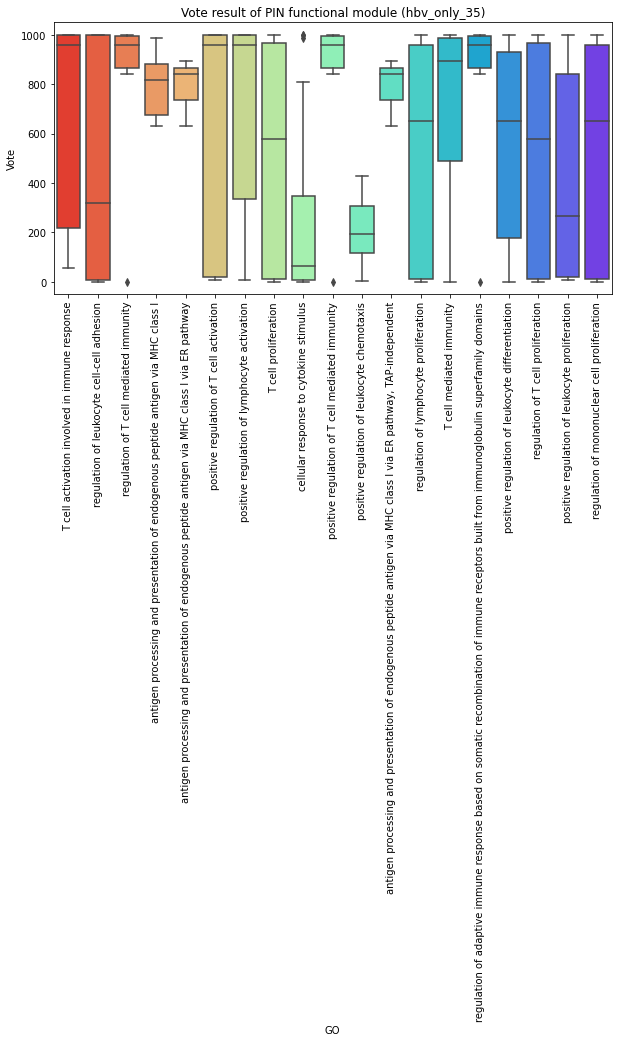

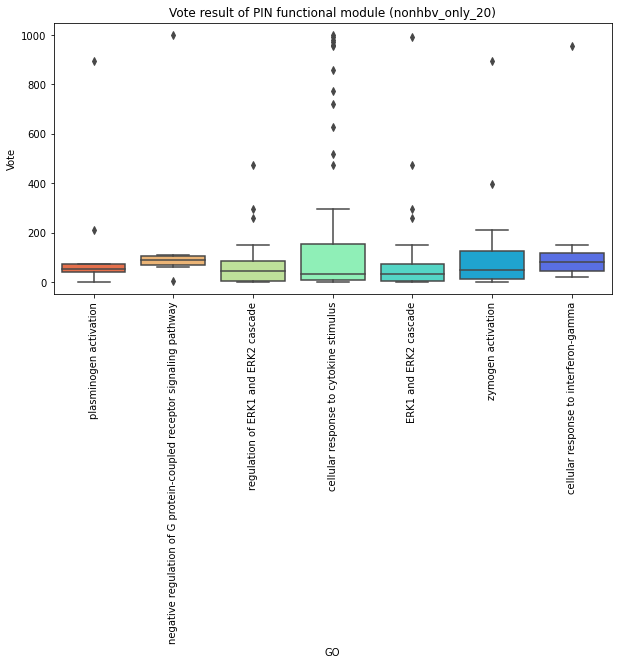

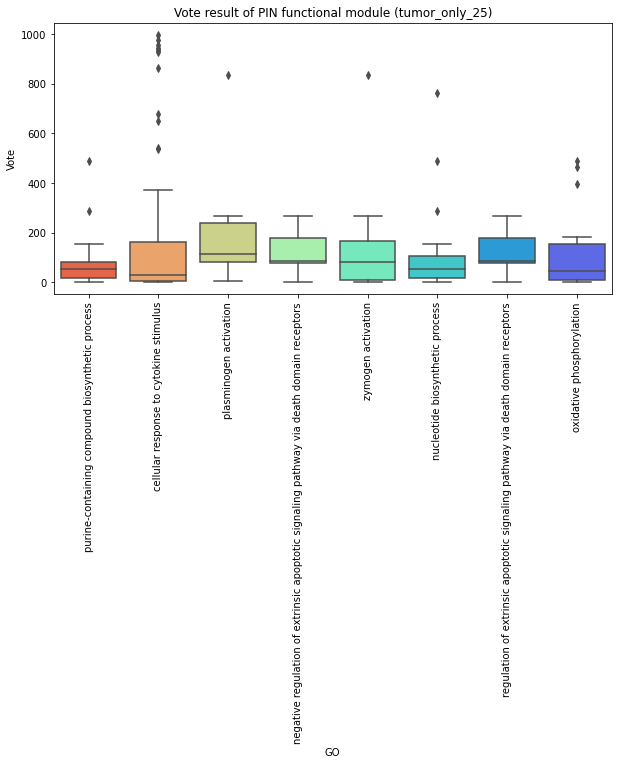

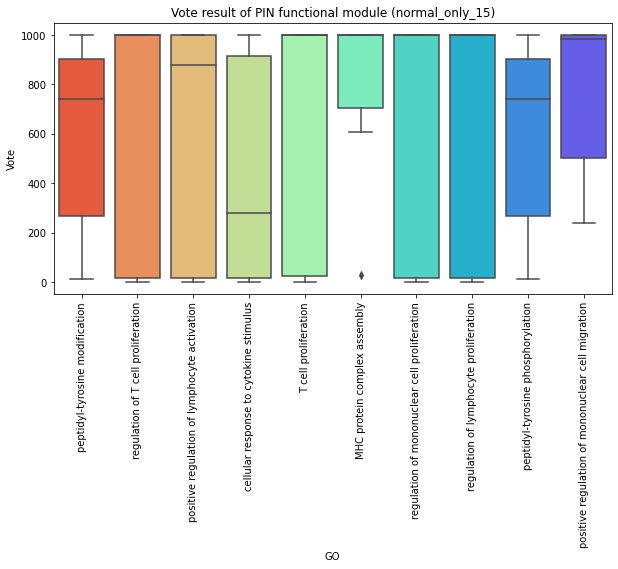

In [15]:
module_d = {'PIN':pin_summary,'GRN' : grn_summary}
for ppi in ['GRN','PIN'] :
    module = module_d[ppi]
    go_info = module.functional_module_goinfo()
    for condition in module.condition :
        vote_df = pd.read_csv('/home/bruce1996/data/LIHC_anomaly_detection/functional_profiling/module_vote_result/%s_funModu_vote_result_%s.txt' % (ppi,condition),sep='\t',index_col=0)
        plt.figure(figsize=(10,5))
        ax = sns.boxplot(data=vote_df,x='GO',y='Vote',palette='rainbow_r')
        label = [x.get_text() for x in ax.get_xticklabels()]
        description = [go_info[condition][x][0] for x in label]
        ax.set_xticklabels(description,rotation=90)
        ax.set_title("Vote result of %s functional module (%s)" % (ppi,condition))
        plt.savefig("/home/bruce1996/data/LIHC_anomaly_detection/fig/functional_module/vote_distribution/%s_funModu_vote_result_%s.png" % (ppi,condition),dpi = 300,bbox_inches='tight')